### Import libraries and set global options

In [1]:
from importlib import import_module
import logging
from os import path
import sys
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

SCRIPT_DIR = path.dirname(path.abspath('__file__'))
sys.path.append(path.dirname(SCRIPT_DIR))
sys.dont_write_bytecode = True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from darts.timeseries import TimeSeries

from library.datasets import get_dataframe_summarized, standarize, StandarizeMethod
from library.depresjon import get_measured_days, read_activity_dataset, read_scores_dataset
from library.model_persistence import load_model
from library.timeseries import extract_ts_features, ComputeFeatures

from sklearn.metrics import pairwise_distances, confusion_matrix, classification_report

from sklearn.neighbors import NearestCentroid
from sklearn.utils.extmath import softmax

from typing import Any, Union


%matplotlib inline

In [3]:
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

seed = 90

random.seed(seed)
np.random.seed(seed)

### Define some helpers

In [4]:
def get_epsilon():
    return sys.float_info.epsilon

def transform_dataset(
    dataset_id: str,
    df: pd.DataFrame,
    frequency: str = '1T',
    summarize_method: str = 'sum',
    standarize_method: int = StandarizeMethod.DEFAULT,
    remove_outliers: bool = False
) -> pd.DataFrame:
    df_grouped = get_dataframe_summarized(df, frequency, summarize_method)
    df_grouped = df_grouped.rename(columns={'index': 'timestamp'})
    df_grouped['id'] = dataset_id
    df_grouped['activity'] = standarize(
        df_grouped.activity.to_numpy(),
        method = standarize_method,
        remove_outliers = remove_outliers
    )
    return df_grouped

def load_features(features_file_path:str) -> str:
    f = open(features_file_path, 'r')
    features_names = [line.strip() for line in f.readlines()]
    f.close()
    return features_names

def predict_proba(model, features):
    if isinstance(model, NearestCentroid):
        distances = pairwise_distances(features, model.centroids_, metric=model.metric)
        return softmax(distances)

    return model.predict_proba(features)

def get_args_for_model(model_class: str):
    if model_class == 'NaiveSeasonal':
        return { 'K': 168 }
    
    if model_class == 'XGBModel':
        return { 'lags': 24, 'random_state': seed }
    
    if model_class == 'ExponentialSmoothing':
        return { 'random_state': seed }
    
    if model_class == 'Prophet':
        return { 'floor': 0 }
    
    if model_class == 'FFT':
        return { 'nr_freqs_to_keep': 24 }

    return {}

def load_forecasting_model(model_class: str, model_path: str) -> Any:
    module = sys.modules['darts.models'] if 'darts.models' in sys.modules else import_module('darts.models')
    args = get_args_for_model(model_class)
    instance = getattr(module, model_class)(**args)
    instance.load(model_path)
    return instance

def extract_features_forecast(
    current_data: pd.DataFrame,
    forecasted_data: pd.DataFrame,
    samples_from_current_data: int = 1,
    samples_from_forecasted_data: int = 1
):
    return extract_ts_features(
        df = pd.concat(
            [
                current_data.tail(samples_from_current_data),
                forecasted_data.head(samples_from_forecasted_data)
            ],
            ignore_index = False
        ).reset_index(),
        compute_features = ComputeFeatures.ALL,
        column_id = 'id',
        column_sort = 'timestamp',
        column_value = 'activity',
        disable_progressbar = True
    )

def predict_activity_and_extract_features(
    id: str,
    model: any,
    data: TimeSeries,
):
    df_forecast = model.predict(24 * 7).pd_dataframe()
    df_forecast['id'] = id
    
    # features 3 days forecast activity mean
    features_3days_forecast = extract_features_forecast(
        current_data = data,
        forecasted_data = df_forecast,
        samples_from_current_data = 24 * 11,
        samples_from_forecasted_data = 24 * 3
    )

    # features 5 days forecast activity mean
    features_5days_forecast = extract_features_forecast(
        current_data = data,
        forecasted_data = df_forecast,
        samples_from_current_data = 24 * 9,
        samples_from_forecasted_data = 24 * 5
    )

    # features 7 days forecast activity mean
    features_7days_forecast = extract_features_forecast(
        current_data = data,
        forecasted_data = df_forecast,
        samples_from_current_data = 24 * 7,
        samples_from_forecasted_data = 24 * 7
    )
    
    return features_3days_forecast, features_5days_forecast, features_7days_forecast

### Define global variables

In [5]:
DATASETS_PATH = path.realpath(path.join(SCRIPT_DIR, '..', '..', 'dataset'))

RESULTS_PATH = path.realpath(path.join(SCRIPT_DIR, '..', '..', 'results'))

CLASSIFICATION_MODELS_PATH = path.realpath(
    path.join(RESULTS_PATH, 'classification', 'models', 'final')
)

CLASSIFICATION_MODELS_FEATURES_PATH = path.realpath(
    path.join(SCRIPT_DIR, '..', '..', 'dataset', 'features')
)

FORECASTING_MODELS_PATH = path.realpath(
    path.join(RESULTS_PATH, 'forecasting', 'models')
)

### Load scores dataset

In [6]:
# scores dataset
df_scores = read_scores_dataset(f'{DATASETS_PATH}/original/scores.csv')
df_scores.head()

days  gender    age  afftype  melanch  inpatient    edu  \
number                                                                 
condition_1    11       2  35-39   2.0000   2.0000     2.0000   6-10   
condition_2    18       2  40-44   1.0000   2.0000     2.0000   6-10   
condition_3    13       1  45-49   2.0000   2.0000     2.0000   6-10   
condition_4    13       2  25-29   2.0000   2.0000     2.0000  11-15   
condition_5    13       2  50-54   2.0000   2.0000     2.0000  11-15   

             marriage   work  madrs1  madrs2  
number                                        
condition_1    1.0000 2.0000 19.0000 19.0000  
condition_2    2.0000 2.0000 24.0000 11.0000  
condition_3    2.0000 2.0000 24.0000 25.0000  
condition_4    1.0000 1.0000 20.0000 16.0000  
condition_5    2.0000 2.0000 26.0000 26.0000

### Load activity datasets

In [7]:
hourly_activity_datasets = {}
for file, row in df_scores.iterrows():
    folder = file.split('_')[0]
    days = get_measured_days(df_scores, file)
    df = read_activity_dataset(f'{DATASETS_PATH}/original/{folder}/{file}.csv', days)
    
    hourly_activity_datasets[file] = {
        'mean': transform_dataset(
            file,
            df,
            frequency = '1H',
            summarize_method = 'mean',
            standarize_method = StandarizeMethod.ROBUST,
            remove_outliers = False
        ),
        'median': transform_dataset(
            file,
            df,
            frequency = '1H',
            summarize_method = 'median',
            standarize_method = StandarizeMethod.DEFAULT,
            remove_outliers = False
        )
    }

In [8]:
hourly_activity_datasets['condition_1']['mean'].head()

timestamp  activity           id
0 2003-05-08 00:00:00   -0.6786  condition_1
1 2003-05-08 01:00:00   -0.7073  condition_1
2 2003-05-08 02:00:00   -0.6854  condition_1
3 2003-05-08 03:00:00   -0.7077  condition_1
4 2003-05-08 04:00:00   -0.6477  condition_1

In [9]:
hourly_activity_datasets['condition_1']['median'].head()

timestamp  activity           id
0 2003-05-08 00:00:00   -0.6584  condition_1
1 2003-05-08 01:00:00   -0.6584  condition_1
2 2003-05-08 02:00:00   -0.6584  condition_1
3 2003-05-08 03:00:00   -0.6584  condition_1
4 2003-05-08 04:00:00   -0.6584  condition_1

#### Plot activity

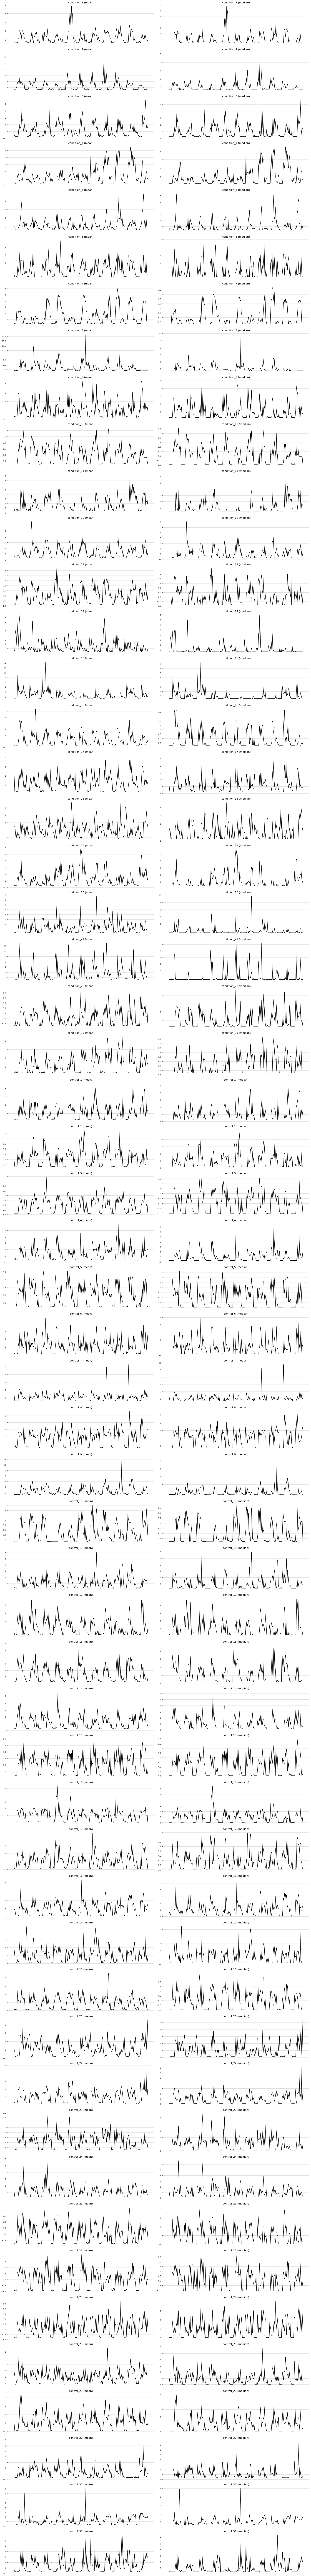

In [10]:
fig, axes = plt.subplots(
    nrows = len(hourly_activity_datasets),
    ncols = 2,
    figsize = (20, len(hourly_activity_datasets) * 3)
)

index = 0
for file, dfs in hourly_activity_datasets.items():
    dfs['mean'].activity.plot(ax = axes[index, 0], title=f'{file} (mean)', xticks=[])
    dfs['median'].activity.plot(ax = axes[index, 1], title=f'{file} (median)', xticks=[])
    index += 1
    
fig.tight_layout()
plt.show()

### Load models

#### Load classification models

In [11]:
classification_model_mean = load_model(
    path.abspath(
        f'{CLASSIFICATION_MODELS_PATH}/model__rlo__features_all_1H_mean_standarized_zscore-robust_outliers_yes__10-features__80-20__loo.skops'
    )
)
classification_model_median = load_model(
    path.abspath(
        f'{CLASSIFICATION_MODELS_PATH}/model__rlo__features_all_1H_median_standarized_zscore_outliers_no__5-features__80-20_av__loo.skops'
    )
)

In [12]:
classification_model_mean

LogisticRegressionCV(class_weight='balanced', cv=5, random_state=90,
                     solver='liblinear')

In [13]:
classification_model_median

LogisticRegressionCV(class_weight='balanced', cv=5, random_state=90,
                     solver='liblinear')

#### Load forecasting models

In [14]:
# load forecasting scores dataset (MAPE:min)
df_forecasting_scores = read_scores_dataset(path.realpath(path.join(RESULTS_PATH, 'forecasting', 'scores', 'scores_forecasting_models__MAPE_min.csv')))
df_forecasting_scores.head()

score_metric criteria best_model_mean  score_best_model_mean  \
number                                                                     
condition_1         MAPE      min   NaiveSeasonal               197.6005   
condition_2         MAPE      min   NaiveSeasonal               194.3737   
condition_3         MAPE      min         Prophet               135.7124   
condition_4         MAPE      min        XGBModel              1411.2185   
condition_5         MAPE      min         Prophet               341.0560   

                                               model_file_mean  \
number                                                           
condition_1  condition_1__hourly_mean__NaiveSeasonal__MAPE_...   
condition_2  condition_2__hourly_mean__NaiveSeasonal__MAPE_...   
condition_3    condition_3__hourly_mean__Prophet__MAPE_min.pkl   
condition_4   condition_4__hourly_mean__XGBModel__MAPE_min.pkl   
condition_5    condition_5__hourly_mean__Prophet__MAPE_min.pkl   

                best_model_median  score_best_model_median  \
number                                                       
condition_1         NaiveSeasonal                 106.2050   
condition_2              XGBModel                 375.4673   
condition_3  ExponentialSmoothing                 190.1347   
condition_4              XGBModel                 122.4244   
condition_5         NaiveSeasonal                 120.5166   

                                             model_file_median  
number                                                          
condition_1  condition_1__hourly_median__NaiveSeasonal__MAP...  
condition_2  condition_2__hourly_median__XGBModel__MAPE_min...  
condition_3  condition_3__hourly_median__ExponentialSmoothi...  
condition_4  condition_4__hourly_median__XGBModel__MAPE_min...  
condition_5  condition_5__hourly_median__NaiveSeasonal__MAP...

In [15]:
forecasting_models = {}
for id, row in df_forecasting_scores.iterrows():
    df_mean = hourly_activity_datasets[id]['mean'].set_index('timestamp')
    df_median = hourly_activity_datasets[id]['median'].set_index('timestamp')

    ts_hourly_mean = TimeSeries.from_series(df_mean.activity + get_epsilon())
    ts_hourly_median = TimeSeries.from_series(df_median.activity + get_epsilon())
    
    forecasting_models[id] = {
        'mean': load_forecasting_model(
            model_class = row['best_model_mean'],
            model_path = path.realpath(
                path.join(RESULTS_PATH, 'forecasting', 'models', row['model_file_mean'])
            )
        ).fit(ts_hourly_mean),
        'median': load_forecasting_model(
            model_class = row['best_model_median'],
            model_path = path.realpath(
                path.join(RESULTS_PATH, 'forecasting', 'models', row['model_file_median'])
            )
        ).fit(ts_hourly_median)
    }

### Load features for classification

In [16]:
features_names_mean = load_features(
    path.abspath(
        path.join(CLASSIFICATION_MODELS_FEATURES_PATH, 'train', '80-20', '10-features', 'rlo', 'features_all_1H_mean_standarized_zscore-robust_outliers_yes.txt')
    )
)

features_names_median = load_features(
    path.abspath(
        path.join(CLASSIFICATION_MODELS_FEATURES_PATH, 'train', '80-20_av', '5-features', 'rlo', 'features_all_1H_median_standarized_zscore_outliers_no.txt')
    )
)


In [17]:
features_names_mean

['activity__large_standard_deviation__r_0.2',
 'activity__autocorrelation__lag_1',
 'activity__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)',
 'activity__fft_coefficient__attr_"abs"__coeff_13',
 'activity__fft_coefficient__attr_"abs"__coeff_22',
 'activity__friedrich_coefficients__coeff_0__m_3__r_30',
 'activity__max_langevin_fixed_point__m_3__r_30',
 'activity__ratio_beyond_r_sigma__r_1.5']

In [18]:
features_names_median

['activity__c3__lag_2',
 'activity__quantile__q_0.6',
 'activity__fft_coefficient__attr_"abs"__coeff_88',
 'activity__fft_coefficient__attr_"abs"__coeff_95',
 'activity__fft_coefficient__attr_"angle"__coeff_8']

### Generate features datasets for data

In [19]:
features_datasets = {
    'mean': pd.DataFrame(),
    'median': pd.DataFrame()
}
for file, dfs in hourly_activity_datasets.items():
    extracted_features_mean = extract_ts_features(
        dfs['mean'],
        ComputeFeatures.ALL,
        column_id = 'id',
        column_sort = 'timestamp',
        column_value = 'activity',
        disable_progressbar = True
    )
    
    extracted_features_median = extract_ts_features(
        dfs['median'],
        ComputeFeatures.ALL,
        column_id = 'id',
        column_sort = 'timestamp',
        column_value = 'activity',
        disable_progressbar = True
    )
            
    features_datasets['mean'] = pd.concat([
        features_datasets['mean'],
        extracted_features_mean,
    ])
    
    features_datasets['median'] = pd.concat([
        features_datasets['median'],
        extracted_features_median,
    ])
    
features_datasets['mean'] = features_datasets['mean'][features_names_mean]
features_datasets['median'] = features_datasets['median'][features_names_median]

In [20]:
features_datasets['mean'].head()

activity__large_standard_deviation__r_0.2  \
condition_1                                     0.0000   
condition_2                                     0.0000   
condition_3                                     0.0000   
condition_4                                     1.0000   
condition_5                                     0.0000   

             activity__autocorrelation__lag_1  \
condition_1                            0.7478   
condition_2                            0.5977   
condition_3                            0.6250   
condition_4                            0.7886   
condition_5                            0.6173   

             activity__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)  \
condition_1                                            -0.5717                 
condition_2                                            -1.8745                 
condition_3                                            -0.5190                 
condition_4                                            -1.0626                 
condition_5                                            -0.3830                 

             activity__fft_coefficient__attr_"abs"__coeff_13  \
condition_1                                          16.7971   
condition_2                                           9.7843   
condition_3                                          24.6683   
condition_4                                          24.2909   
condition_5                                          13.9064   

             activity__fft_coefficient__attr_"abs"__coeff_22  \
condition_1                                           3.5685   
condition_2                                          46.0603   
condition_3                                          29.9191   
condition_4                                          21.4161   
condition_5                                          74.4109   

             activity__friedrich_coefficients__coeff_0__m_3__r_30  \
condition_1                                             0.0357      
condition_2                                             0.0457      
condition_3                                             0.0004      
condition_4                                            -0.0237      
condition_5                                             0.0161      

             activity__max_langevin_fixed_point__m_3__r_30  \
condition_1                                         6.7512   
condition_2                                         7.4471   
condition_3                                       579.6694   
condition_4                                         0.8897   
condition_5                                         9.6190   

             activity__ratio_beyond_r_sigma__r_1.5  
condition_1                                 0.0530  
condition_2                                 0.0644  
condition_3                                 0.0833  
condition_4                                 0.1023  
condition_5                                 0.0795

In [21]:
features_datasets['median'].head()

activity__c3__lag_2  activity__quantile__q_0.6  \
condition_1               0.5381                    -0.2494   
condition_2               0.0630                    -0.1142   
condition_3               0.0920                    -0.1455   
condition_4               0.7540                    -0.2316   
condition_5               0.1191                    -0.2946   

             activity__fft_coefficient__attr_"abs"__coeff_88  \
condition_1                                           7.2778   
condition_2                                          13.8430   
condition_3                                          10.1541   
condition_4                                           0.4933   
condition_5                                           5.2004   

             activity__fft_coefficient__attr_"abs"__coeff_95  \
condition_1                                          11.8720   
condition_2                                           6.7508   
condition_3                                           8.1273   
condition_4                                           3.7705   
condition_5                                           8.5820   

             activity__fft_coefficient__attr_"angle"__coeff_8  
condition_1                                         -127.7287  
condition_2                                          -85.6678  
condition_3                                           92.9977  
condition_4                                          -51.9737  
condition_5                                         -142.3402

### Perform classification

#### Init results datasets

In [22]:
preds = {
    'mean': pd.DataFrame(
        columns = ['current', '3_days', '5_days', '7_days'],
        index=df_scores.index
    ),
    'median': pd.DataFrame(
        columns = ['current', '3_days', '5_days', '7_days'],
        index=df_scores.index
    )
}

classification = {
    'mean': pd.DataFrame(
        columns = ['condition', 'current', '3_days', '5_days', '7_days'],
        index=df_scores.index
    ),
    'median': pd.DataFrame(
        columns = ['condition', 'current', '3_days', '5_days', '7_days'],
        index=df_scores.index
    )
}

classification['mean']['condition'] = classification['mean']['condition'].index.map(lambda value: int(value.startswith('condition')))
classification['median']['condition'] = classification['median']['condition'].index.map(lambda value: int(value.startswith('condition')))

#### Perform classification for latest 11 days

In [23]:
preds['mean']['current'] = predict_proba(classification_model_mean, features_datasets['mean'])[:,1]
classification['mean']['current'] = classification_model_mean.predict(features_datasets['mean'])

In [24]:
preds['median']['current'] = predict_proba(classification_model_median, features_datasets['median'])[:,1]
classification['median']['current'] = classification_model_median.predict(features_datasets['median'])

#### Forecast activity data and generate features datasets for the last 15 days

In [25]:
forecast_features_datasets = {
    'mean': {
        '3_days': pd.DataFrame(),
        '5_days': pd.DataFrame(),
        '7_days': pd.DataFrame()
    },
    'median': {
        '3_days': pd.DataFrame(),
        '5_days': pd.DataFrame(),
        '7_days': pd.DataFrame()
    }
}
for id, dfs in hourly_activity_datasets.items():
    forecast_model_mean = forecasting_models[id]['mean']
    forecast_model_median = forecasting_models[id]['median']
    
    df_mean = dfs['mean'].set_index('timestamp')
    df_median = dfs['median'].set_index('timestamp')

    # get features for activity mean forecast
    features_3days_forecast_mean, features_5days_forecast_mean, features_7days_forecast_mean = predict_activity_and_extract_features(
        id = id,
        model = forecast_model_mean,
        data = df_mean
    )
                        
    forecast_features_datasets['mean']['3_days'] = pd.concat([
        forecast_features_datasets['mean']['3_days'],
        features_3days_forecast_mean,
    ])
    
    forecast_features_datasets['mean']['5_days'] = pd.concat([
        forecast_features_datasets['mean']['5_days'],
        features_5days_forecast_mean,
    ])
    
    forecast_features_datasets['mean']['7_days'] = pd.concat([
        forecast_features_datasets['mean']['7_days'],
        features_7days_forecast_mean,
    ])

    # get features for activity median forecast
    features_3days_forecast_median, features_5days_forecast_median, features_7days_forecast_median = predict_activity_and_extract_features(
        id = id,
        model = forecast_model_median,
        data = df_median
    )

    forecast_features_datasets['median']['3_days'] = pd.concat([
        forecast_features_datasets['median']['3_days'],
        features_3days_forecast_median,
    ])
    
    forecast_features_datasets['median']['5_days'] = pd.concat([
        forecast_features_datasets['median']['5_days'],
        features_5days_forecast_median,
    ])
    
    forecast_features_datasets['median']['7_days'] = pd.concat([
        forecast_features_datasets['median']['7_days'],
        features_7days_forecast_median,
    ])

# remove unsused features 
forecast_features_datasets['mean']['3_days'] = forecast_features_datasets['mean']['3_days'][features_names_mean]
forecast_features_datasets['mean']['5_days'] = forecast_features_datasets['mean']['5_days'][features_names_mean]
forecast_features_datasets['mean']['7_days'] = forecast_features_datasets['mean']['7_days'][features_names_mean]

forecast_features_datasets['median']['3_days'] = forecast_features_datasets['median']['3_days'][features_names_median]
forecast_features_datasets['median']['5_days'] = forecast_features_datasets['median']['5_days'][features_names_median]
forecast_features_datasets['median']['7_days'] = forecast_features_datasets['median']['7_days'][features_names_median]

#### Perform classification for latest 14 days (3 forecasted days and 11 previous days)

In [26]:
preds['mean']['3_days'] = predict_proba(classification_model_mean, forecast_features_datasets['mean']['3_days'])[:,1]
preds['median']['3_days'] = predict_proba(classification_model_median, forecast_features_datasets['median']['3_days'])[:,1]

preds['mean']['3_days'] = preds['mean']['3_days'] * preds['mean']['current']
preds['median']['3_days'] = preds['median']['3_days'] * preds['median']['current']

classification['mean']['3_days'] = classification_model_mean.predict(forecast_features_datasets['mean']['3_days'])
classification['median']['3_days'] = classification_model_median.predict(forecast_features_datasets['median']['3_days'])

#### Perform classification for latest 14 days (5 forecasted days and 9 previous days)

In [27]:
preds['mean']['5_days'] = predict_proba(classification_model_mean, forecast_features_datasets['mean']['5_days'])[:,1]
preds['median']['5_days'] = predict_proba(classification_model_median, forecast_features_datasets['median']['5_days'])[:,1]

preds['mean']['5_days'] = preds['mean']['5_days'] * preds['mean']['current']
preds['median']['5_days'] = preds['median']['5_days'] * preds['median']['current']

classification['mean']['5_days'] = classification_model_mean.predict(forecast_features_datasets['mean']['5_days'])
classification['median']['5_days'] = classification_model_median.predict(forecast_features_datasets['median']['5_days'])

#### Perform classification for latest 14 days (7 forecasted days and 7 previous days)

In [28]:
preds['mean']['7_days'] = predict_proba(classification_model_mean, forecast_features_datasets['mean']['7_days'])[:,1]
preds['median']['7_days'] = predict_proba(classification_model_median, forecast_features_datasets['median']['7_days'])[:,1]

preds['mean']['7_days'] = preds['mean']['7_days'] * preds['mean']['current']
preds['median']['7_days'] = preds['median']['7_days'] * preds['median']['current']

classification['mean']['7_days'] = classification_model_mean.predict(forecast_features_datasets['mean']['7_days'])
classification['median']['7_days'] = classification_model_median.predict(forecast_features_datasets['median']['7_days'])

### Show classification results

In [29]:
preds['mean'].T

number   condition_1  condition_2  condition_3  condition_4  condition_5  \
current       0.0002       0.0000       0.0000       0.9133       0.0103   
3_days        0.0000       0.0000       0.0000       0.0446       0.0000   
5_days        0.0000       0.0000       0.0000       0.6156       0.0005   
7_days        0.0000       0.0000       0.0000       0.5825       0.0013   

number   condition_6  condition_7  condition_8  condition_9  condition_10  \
current       0.0040       0.8091       0.0000       0.4719        0.7066   
3_days        0.0000       0.7496       0.0000       0.0044        0.3981   
5_days        0.0000       0.8048       0.0000       0.4715        0.4909   
7_days        0.0014       0.0448       0.0000       0.1434        0.0006   

number   condition_11  condition_12  condition_13  condition_14  condition_15  \
current        0.0091        0.0017        0.9740        0.0000        0.0000   
3_days         0.0000        0.0000        0.1088        0.0000        0.0000   
5_days         0.0000        0.0001        0.1380        0.0000        0.0000   
7_days         0.0000        0.0004        0.8744        0.0000        0.0000   

number   condition_16  condition_17  condition_18  condition_19  condition_20  \
current        0.0125        0.3554        0.0558        0.3289        0.0042   
3_days         0.0000        0.0000        0.0051        0.0000        0.0000   
5_days         0.0000        0.0001        0.0145        0.0000        0.0000   
7_days         0.0006        0.0332        0.0426        0.0002        0.0000   

number   condition_21  condition_22  condition_23  control_1  control_2  \
current        0.1589        0.9613        0.4548     0.0717     0.2668   
3_days         0.0000        0.9072        0.2512     0.0000     0.0009   
5_days         0.0000        0.4678        0.4502     0.0000     0.0000   
7_days         0.0000        0.7610        0.4492     0.0003     0.0000   

number   control_3  control_4  control_5  control_6  control_7  control_8  \
current     0.1047     0.0011     0.3568     0.1019     0.0000     0.0010   
3_days      0.0011     0.0000     0.0354     0.0000     0.0000     0.0000   
5_days      0.0006     0.0000     0.0604     0.0000     0.0000     0.0000   
7_days      0.0015     0.0000     0.3334     0.0000     0.0000     0.0000   

number   control_9  control_10  control_11  control_12  control_13  \
current     0.0000      0.1573      0.0000      0.0651      0.0002   
3_days      0.0000      0.1553      0.0000      0.0000      0.0000   
5_days      0.0000      0.1464      0.0000      0.0000      0.0000   
7_days      0.0000      0.1570      0.0000      0.0000      0.0000   

number   control_14  control_15  control_16  control_17  control_18  \
current      0.0000      0.0132      0.0000      0.0244      0.0194   
3_days       0.0000      0.0003      0.0000      0.0000      0.0001   
5_days       0.0000      0.0089      0.0000      0.0000      0.0000   
7_days       0.0000      0.0128      0.0000      0.0000      0.0004   

number   control_19  control_20  control_21  control_22  control_23  \
current      0.0001      0.0005      0.0000      0.0000      0.0001   
3_days       0.0000      0.0000      0.0000      0.0000      0.0000   
5_days       0.0000      0.0000      0.0000      0.0000      0.0000   
7_days       0.0000      0.0000      0.0000      0.0000      0.0000   

number   control_24  control_25  control_26  control_27  control_28  \
current      0.0000      0.0013      0.0015      0.0375      0.0000   
3_days       0.0000      0.0000      0.0001      0.0003      0.0000   
5_days       0.0000      0.0001      0.0012      0.0005      0.0000   
7_days       0.0000      0.0000      0.0005      0.0040      0.0000   

number   control_29  control_30  control_31  control_32  
current      0.2661      0.0001      0.0001      0.0010  
3_days       0.0001      0.0000      0.0000      0.0003  
5_days       0.0785      0.0000      0.0000      0.0003  
7_days  

In [30]:
classification['mean'].T

number     condition_1  condition_2  condition_3  condition_4  condition_5  \
condition            1            1            1            1            1   
current              0            0            0            1            0   
3_days               0            0            0            0            0   
5_days               0            0            0            1            0   
7_days               0            0            0            1            0   

number     condition_6  condition_7  condition_8  condition_9  condition_10  \
condition            1            1            1            1             1   
current              0            1            0            0             1   
3_days               0            1            0            0             1   
5_days               0            1            0            1             1   
7_days               0            0            0            0             0   

number     condition_11  condition_12  condition_13  condition_14  \
condition             1             1             1             1   
current               0             0             1             0   
3_days                0             0             0             0   
5_days                0             0             0             0   
7_days                0             0             1             0   

number     condition_15  condition_16  condition_17  condition_18  \
condition             1             1             1             1   
current               0             0             0             0   
3_days                0             0             0             0   
5_days                0             0             0             0   
7_days                0             0             0             1   

number     condition_19  condition_20  condition_21  condition_22  \
condition             1             1             1             1   
current               0             0             0             1   
3_days                0             0             0             1   
5_days                0             0             0             0   
7_days                0             0             0             1   

number     condition_23  control_1  control_2  control_3  control_4  \
condition             1          0          0          0          0   
current               0          0          0          0          0   
3_days                1          0          0          0          0   
5_days                1          0          0          0          0   
7_days                1          0          0          0          0   

number     control_5  control_6  control_7  control_8  control_9  control_10  \
condition          0          0          0          0          0           0   
current            0          0          0          0          0           0   
3_days             0          0          0          0          0           1   
5_days             0          0          0          0          0           1   
7_days             1          0          0          0          0           1   

number     control_11  control_12  control_13  control_14  control_15  \
condition           0           0           0           0           0   
current             0           0           0           0           0   
3_days              0           0           0           0           0   
5_days              0           0           0           0           1   
7_days              0           0           0           1           1   

number     control_16  control_17  control_18  control_19  control_20  \
condition           0           0           0           0           0   
current             0           0           0           0           0   
3_days              0           0           0           0           0   
5_days              0           0           0           0           0   
7_days              0           0           0           0           0   

number     control_21  co

In [31]:
preds['median'].T

number   condition_1  condition_2  condition_3  condition_4  condition_5  \
current       0.9957       0.4959       0.2925       0.9866       0.9881   
3_days        0.5023       0.4828       0.1585       0.8487       0.9752   
5_days        0.2090       0.4843       0.1051       0.9857       0.7818   
7_days        0.8954       0.4815       0.0370       0.9849       0.1790   

number   condition_6  condition_7  condition_8  condition_9  condition_10  \
current       0.9245       0.9629       0.9998       0.9145        0.8663   
3_days        0.0351       0.9551       0.6709       0.0361        0.0642   
5_days        0.5463       0.9145       0.4296       0.8310        0.0656   
7_days        0.5574       0.8438       0.5872       0.8526        0.4283   

number   condition_11  condition_12  condition_13  condition_14  condition_15  \
current        0.9853        0.6283        0.8832        0.9913        0.9567   
3_days         0.2738        0.5941        0.3472        0.5584        0.7413   
5_days         0.0588        0.3349        0.2806        0.0970        0.6664   
7_days         0.7919        0.1377        0.6880        0.0297        0.9027   

number   condition_16  condition_17  condition_18  condition_19  condition_20  \
current        0.9594        0.2765        0.3174        0.8439        0.6234   
3_days         0.9410        0.2505        0.1347        0.7232        0.5300   
5_days         0.7713        0.2495        0.0956        0.4597        0.5723   
7_days         0.8628        0.2359        0.1485        0.2483        0.6089   

number   condition_21  condition_22  condition_23  control_1  control_2  \
current        0.9172        0.9032        0.8948     0.0957     0.5471   
3_days         0.3676        0.8656        0.0347     0.0021     0.0672   
5_days         0.0343        0.6343        0.7289     0.0297     0.0057   
7_days         0.0008        0.0887        0.2556     0.0155     0.0033   

number   control_3  control_4  control_5  control_6  control_7  control_8  \
current     0.0342     0.2637     0.0187     0.0639     0.0214     0.2203   
3_days      0.0013     0.2498     0.0007     0.0618     0.0098     0.0388   
5_days      0.0012     0.2198     0.0017     0.0430     0.0050     0.0029   
7_days      0.0002     0.0050     0.0092     0.0148     0.0088     0.0015   

number   control_9  control_10  control_11  control_12  control_13  \
current     0.9421      0.2293      0.2712      0.2870      0.0236   
3_days      0.9396      0.1554      0.1424      0.2686      0.0210   
5_days      0.9340      0.0499      0.0467      0.2316      0.0184   
7_days      0.9292      0.0055      0.1390      0.2021      0.0116   

number   control_14  control_15  control_16  control_17  control_18  \
current      0.5555      0.0149      0.0404      0.0739      0.2260   
3_days       0.4100      0.0006      0.0049      0.0655      0.0046   
5_days       0.2783      0.0129      0.0057      0.0694      0.0187   
7_days       0.0696      0.0002      0.0005      0.0694      0.0078   

number   control_19  control_20  control_21  control_22  control_23  \
current      0.0021      0.0011      0.0104      0.4597      0.2403   
3_days       0.0009      0.0000      0.0059      0.1306      0.0258   
5_days       0.0002      0.0003      0.0074      0.0081      0.0055   
7_days       0.0001      0.0003      0.0056      0.0047      0.0156   

number   control_24  control_25  control_26  control_27  control_28  \
current      0.0010      0.1253      0.1718      0.0305      0.0496   
3_days       0.0000      0.1171      0.0892      0.0005      0.0364   
5_days       0.0009      0.0091      0.0762      0.0006      0.0339   
7_days       0.0009      0.0852      0.1234      0.0002      0.0344   

number   control_29  control_30  control_31  control_32  
current      0.1844      0.0015      0.2764      0.6341  
3_days       0.0362      0.0006      0.2748      0.5927  
5_days       0.0299      0.0004      0.1231      0.5864  
7_days  

In [32]:
classification['median'].T

number     condition_1  condition_2  condition_3  condition_4  condition_5  \
condition            1            1            1            1            1   
current              1            0            0            1            1   
3_days               1            1            1            1            1   
5_days               0            1            0            1            1   
7_days               1            1            0            1            0   

number     condition_6  condition_7  condition_8  condition_9  condition_10  \
condition            1            1            1            1             1   
current              1            1            1            1             1   
3_days               0            1            1            0             0   
5_days               1            1            0            1             0   
7_days               1            1            1            1             0   

number     condition_11  condition_12  condition_13  condition_14  \
condition             1             1             1             1   
current               1             1             1             1   
3_days                0             1             0             1   
5_days                0             1             0             0   
7_days                1             0             1             0   

number     condition_15  condition_16  condition_17  condition_18  \
condition             1             1             1             1   
current               1             1             0             0   
3_days                1             1             1             0   
5_days                1             1             1             0   
7_days                1             1             1             0   

number     condition_19  condition_20  condition_21  condition_22  \
condition             1             1             1             1   
current               1             1             1             1   
3_days                1             1             0             1   
5_days                1             1             0             1   
7_days                0             1             0             0   

number     condition_23  control_1  control_2  control_3  control_4  \
condition             1          0          0          0          0   
current               1          0          1          0          0   
3_days                0          0          0          0          1   
5_days                1          0          0          0          1   
7_days                0          0          0          0          0   

number     control_5  control_6  control_7  control_8  control_9  control_10  \
condition          0          0          0          0          0           0   
current            0          0          0          0          1           0   
3_days             0          1          0          0          1           1   
5_days             0          1          0          0          1           0   
7_days             0          0          0          0          1           0   

number     control_11  control_12  control_13  control_14  control_15  \
condition           0           0           0           0           0   
current             0           0           0           1           0   
3_days              1           1           1           1           0   
5_days              0           1           1           1           1   
7_days              1           1           0           0           0   

number     control_16  control_17  control_18  control_19  control_20  \
condition           0           0           0           0           0   
current             0           0           0           0           0   
3_days              0           1           0           0           0   
5_days              0           1           0           0           0   
7_days              0           1           0           0           0   

number     control_21  co

### Analyze results

#### Results for activity mean forecast

##### 3 days

In [33]:
cm_test = confusion_matrix(
    classification['mean']['condition'],
    classification['mean']['3_days'],
    labels=[1, 0]
)
print(classification_report(classification['mean']['condition'], classification['mean']['3_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.61      0.94      0.74        32
           1       0.67      0.17      0.28        23

    accuracy                           0.62        55
   macro avg       0.64      0.56      0.51        55
weighted avg       0.64      0.62      0.55        55

        pred:1  pred:0
true:1       4      19
true:0       2      30


##### 5 days

In [34]:
cm_test = confusion_matrix(
    classification['mean']['condition'],
    classification['mean']['5_days'],
    labels=[1, 0]
)
print(classification_report(classification['mean']['condition'], classification['mean']['5_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.61      0.88      0.72        32
           1       0.56      0.22      0.31        23

    accuracy                           0.60        55
   macro avg       0.58      0.55      0.52        55
weighted avg       0.59      0.60      0.55        55

        pred:1  pred:0
true:1       5      18
true:0       4      28


##### 7 days

In [35]:
cm_test = confusion_matrix(
    classification['mean']['condition'],
    classification['mean']['7_days'],
    labels=[1, 0]
)
print(classification_report(classification['mean']['condition'], classification['mean']['7_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.58      0.78      0.67        32
           1       0.42      0.22      0.29        23

    accuracy                           0.55        55
   macro avg       0.50      0.50      0.48        55
weighted avg       0.51      0.55      0.51        55

        pred:1  pred:0
true:1       5      18
true:0       7      25


#### Results for forecast activity median

##### 3 days

In [36]:
cm_test = confusion_matrix(
    classification['median']['condition'],
    classification['median']['3_days'],
    labels=[1, 0]
)
print(classification_report(classification['median']['condition'], classification['median']['3_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.68      0.53      0.60        32
           1       0.50      0.65      0.57        23

    accuracy                           0.58        55
   macro avg       0.59      0.59      0.58        55
weighted avg       0.60      0.58      0.58        55

        pred:1  pred:0
true:1      15       8
true:0      15      17


##### 5 days

In [37]:
cm_test = confusion_matrix(
    classification['median']['condition'],
    classification['median']['5_days'],
    labels=[1, 0]
)
print(classification_report(classification['median']['condition'], classification['median']['5_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.69      0.62      0.66        32
           1       0.54      0.61      0.57        23

    accuracy                           0.62        55
   macro avg       0.61      0.62      0.61        55
weighted avg       0.63      0.62      0.62        55

        pred:1  pred:0
true:1      14       9
true:0      12      20


##### 7 days

In [38]:
cm_test = confusion_matrix(
    classification['median']['condition'],
    classification['median']['7_days'],
    labels=[1, 0]
)
print(classification_report(classification['median']['condition'], classification['median']['7_days']))
print(
    pd.DataFrame(
        cm_test, 
        index=['true:1', 'true:0'], 
        columns=['pred:1', 'pred:0']
    )
)


              precision    recall  f1-score   support

           0       0.69      0.69      0.69        32
           1       0.57      0.57      0.57        23

    accuracy                           0.64        55
   macro avg       0.63      0.63      0.63        55
weighted avg       0.64      0.64      0.64        55

        pred:1  pred:0
true:1      13      10
true:0      10      22


In [39]:
col = '3_days'
df1 = preds['mean'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] <= 0.5].groupby('condition').count()[col]

condition
0    32
1    21
Name: 3_days, dtype: int64

In [40]:
col = '3_days'
df1 = preds['median'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] <= 0.5].groupby('condition').count()[col]

condition
0    30
1    11
Name: 3_days, dtype: int64

In [41]:
col = '5_days'
df1 = preds['mean'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] <= 0.5].groupby('condition').count()[col]

condition
0    32
1    21
Name: 5_days, dtype: int64

In [42]:
col = '5_days'
df1 = preds['median'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] <= 0.5].groupby('condition').count()[col]

condition
0    30
1    13
Name: 5_days, dtype: int64

In [43]:
col = '7_days'
df1 = preds['mean'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] <= 0.5].groupby('condition').count()[col]

condition
0    32
1    20
Name: 7_days, dtype: int64

In [44]:
col = '7_days'
df1 = preds['median'][col].reset_index()
df1['condition'] = df1.number.map(lambda value: int(value.startswith('condition')))
df1[df1[col] <= 0.5].groupby('condition').count()[col]

condition
0    30
1    12
Name: 7_days, dtype: int64